In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyAMI.client
import pyAMI_nika2
from astropy.cosmology import FlatLambdaCDM #Planck15 as cosmo
import astropy.units as u
import fkplotlib

fkplotlib.use_txfonts()
cosmo = FlatLambdaCDM(70.0, 0.3)
client = pyAMI.client.Client("nika2")

In [2]:
def submit_mql_query(mql, entity="CLUSTER"):
    """
    Submits a MQL query to AMI.

    Parameters
    ----------
    mql : str
        An MQL query. Can be generated using the AMI web 
        interface, by doing the box selection thing and clicking 
        ``More > View MQL query``

    entity : str
        What you are searching for, one of
        ``CLUSTER`` or ``SCAN``

    Returns
    -------
    `pandas.DataFrame`
        A DataFrame of AMI entries matching your query.
        Rows are database entries, and columns are attributes
        (e.g., RA, DEC, z, etc for a cluster; 
        name, tau, source for a scan, etc).
    """

    result = client.execute(
        'SearchQuery -catalog="nika2:production"'
        + f'-entity="{entity.upper()}" -mql="{mql}"',
        format="dom_object",
    ).get_rows()

    return pd.DataFrame(result)


In [3]:
alpha, beta, pivot = (-0.19, 1.79, 6e14) # Planck
#alpha, beta, pivot = (-0.739, 1.79, 3e14) # A10

def scaled_y(cat):
    z = np.array(cat["z"].astype(float))
    y = (np.array(cat["y500"].astype(float)) * 1e-3 * u.arcmin**2).to("rad2").value
    da2y = (cosmo.angular_diameter_distance(z)**2 * y).to("Mpc2").value * 1e4
    return cosmo.efunc(z)**(-2/3) * da2y

def y2m(y):
    return (10**-alpha * y) ** (1.0/beta) * pivot

def m2y(m):
    return 10**alpha * (m/pivot) ** beta

catalog = submit_mql_query("SELECT *")
cat_act = catalog[np.array([name.startswith("A") for name in catalog["shortName"]])]
cat_psz = catalog[np.array([name.startswith("P") for name in catalog["shortName"]])]

<IPython.core.display.Javascript object>


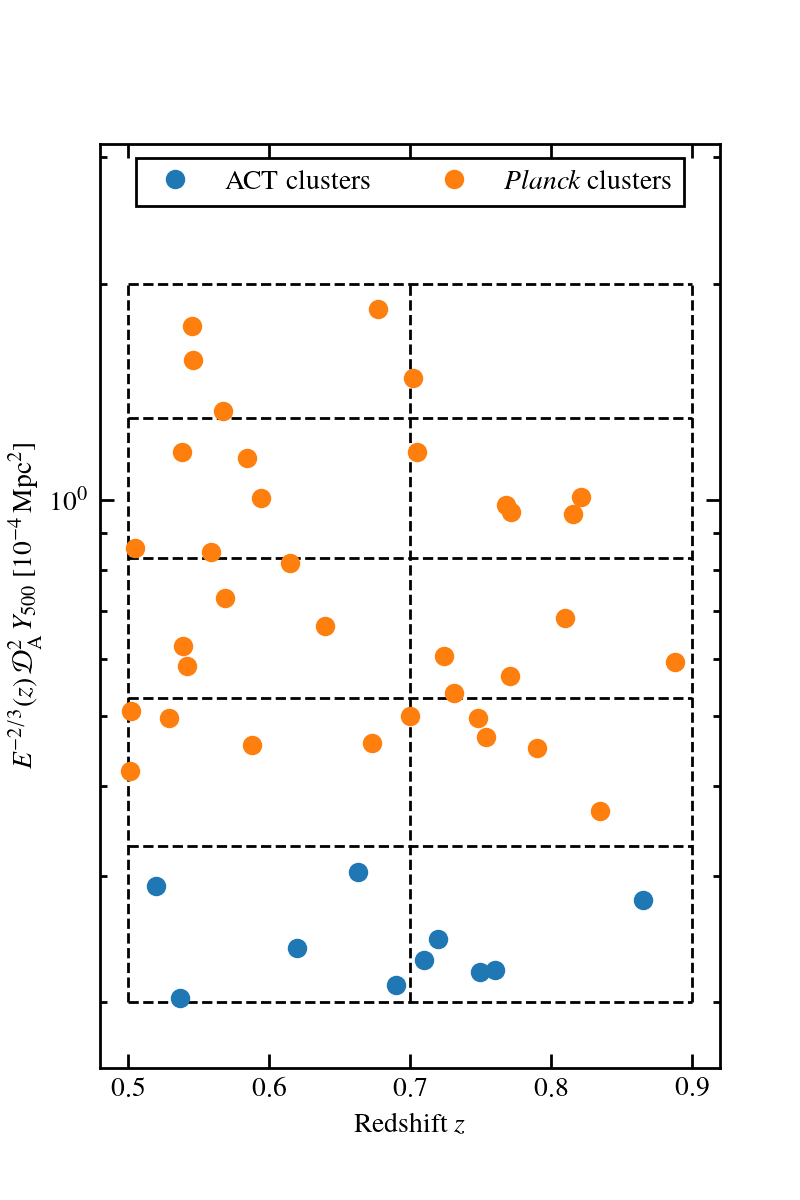

In [10]:

cuts_z = np.array([0.5, 0.7, 0.9])
cuts_y = np.array([0.2, 0.33, 0.53, 0.83, 1.3, 2.0])
cuts_m = y2m(cuts_y) / 1e14

plt.close("all")
fig, ax = plt.subplots(figsize=(4, 6))
#axm = ax.twinx()

ax.plot(cat_act["z"].astype(float), scaled_y(cat_act), "o", label="ACT clusters")
ax.plot(cat_psz["z"].astype(float), scaled_y(cat_psz), "o", label=r"\textit{Planck} clusters")
ax.set_yscale("log")

ax.vlines(cuts_z, cuts_y.min(), cuts_y.max(), color="k", ls="--")
ax.hlines(cuts_y, cuts_z.min(), cuts_z.max(), color="k", ls="--")
ax.set_xlabel(r"Redshift $z$")
ax.set_ylabel(r"$E^{-2/3}(z) \, \mathcal{D}_\mathrm{A}^2 \, Y_{500} \;[10^{-4} \,\mathrm{Mpc^2}]$")
ax.set_ylim(0.8 * np.min(scaled_y(cat_act)), 1.7 * np.max(scaled_y(cat_psz)))

fkplotlib.ax_bothticks(ax)
fkplotlib.ax_legend(ax, ncol=2, loc="upper center")
#fig.savefig("lpsz_sample.pdf")
fig.savefig("/Users/keruzore/Documents/Conferences/mmUniverse_2021/lpsz_sample.pdf")